In [103]:
import numpy as np 
import pandas as pd 
import scanpy as sc
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats

In [77]:
TotalReadCount = 100000

class CellType:
    def __init__(self, CellTypeName, CellProportion, ReadProportion, S_perc, H_perc, S_MSI_perc, H_MSI_perc):
        self.name       = CellTypeName 
        self.CellProportion = CellProportion    # Proportion of this cell type among all other cells
        self.ReadProportion = ReadProportion    # Proportion of reads from this cell type among all other reads
        
        self.ReadCount = TotalReadCount * ReadProportion
        self.S_perc     = S_perc
        self.H_perc     = H_perc
        self.S_MSI_perc = S_MSI_perc
        self.H_MSI_perc = H_MSI_perc
        
        self.S_count = self.ReadCount * self.S_perc
        self.H_count = self.ReadCount * self.H_perc
        self.S_MSI_count = self.S_count * S_MSI_perc
        self.H_MSI_count = self.H_count * H_MSI_perc
        self.MSI_count = self.S_MSI_count + self.H_MSI_count

    def __repr__(self) -> str:
        return self.name
    
    def __str__(self) -> str:
        return self.name

## Approach 1: Estimating read-contribution of each cell type from single-cell RNA-sequencing data

### Joanito et al

In [79]:
adata_J = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Joanito_et_al/2_cell_type_labeled_h5ad/Joanito.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')
adata_J = adata_J.raw.to_adata()

In [86]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata_J.var["mt"] = adata_J.var_names.str.startswith("MT-")
# ribosomal genes
adata_J.var["ribo"] = adata_J.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata_J.var["hb"] = adata_J.var_names.str.contains("^HB[^(P)]")

In [160]:
genes_of_interest = [
    # 'ACTB',
    'MALAT1',
    # 'NEAT1'
]
genes_of_interest_indices = list()

combined_count = list()

for idx, gene in enumerate(adata_J.var.index):
    if gene in genes_of_interest:
        print(gene, idx)
        genes_of_interest_indices.append( idx )

for arr in adata_J.X:
    arr_i = arr.toarray().ravel()
    temp_count = 0 
    for idx in genes_of_interest_indices:
        temp_count += arr_i[idx]
    combined_count.append( temp_count ) 
    
adata_J.obs['combined_count'] = combined_count

MALAT1 16228


In [161]:
ReadProportionByCellType_J = list()
for PatientID, edf in adata_J.obs[(adata_J.obs['BiopsySite2'].isin(['Tumor'])) & (adata_J.obs['Manual_CellType_lvl_1']!='N/A')].groupby('PatientID', observed=True):
    for CellType, edf2 in edf.groupby('Manual_CellType_lvl_3', observed=True):
        ReadProportionByCellType_J.append( [PatientID, CellType, len(edf2)/len(edf), np.sum(edf2['combined_count'])/np.sum(edf['combined_count'])] )
ReadProportionByCellType_J = pd.DataFrame(ReadProportionByCellType_J, columns=['PatientID', 'CellType', 'CellProportion', 'ReadProportion'])

PearsonRResult(statistic=0.8546998378203015, pvalue=1.0333840719309944e-65)

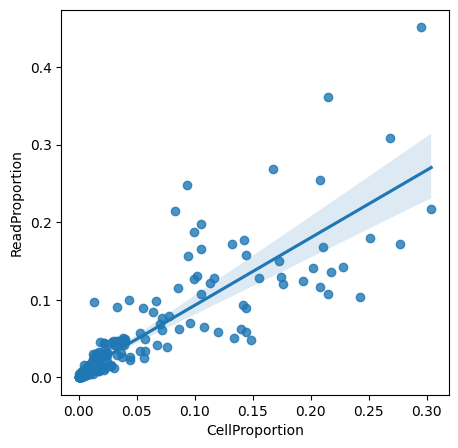

In [162]:
palette_e=[
    'lightcoral', 'tomato' ,'darkred',          # red x 3
    'chocolate', 'darkorange', 'navajowhite',   # orange x 3
    'darkgoldenrod', 'gold',                    # yellow x 2
    'black', 'dimgrey',                         # black x 2
    'yellowgreen', 'darkolivegreen', 'lawngreen', 'forestgreen', # green x 4
    'darkslategrey', 'cyan', 'deepskyblue', 'dodgerblue', # blue x 5
    'mediumslateblue', 'indigo', 'magenta',             # other x 2 
]

plt.figure(figsize=(5, 5))
sns.regplot(data=ReadProportionByCellType_J, 
                x='CellProportion', y='ReadProportion', 
                # **{'linewidth':0}, alpha=0.75, hue='PatientID',
                # legend=None,
                # palette=palette_e,
                )
# sns.lineplot(x=[i*0.1 for i in range(0, 4+1)], y=[i*0.1 for i in range(0, 4+1)], color='black')

scipy.stats.pearsonr( ReadProportionByCellType_J['CellProportion'], ReadProportionByCellType_J['ReadProportion'] )

In [190]:
dict_CellType_to_ReadProportion_J = dict()
for CellType, edf in ReadProportionByCellType_J.groupby('CellType', observed=True):
    print(CellType)
    dict_CellType_to_ReadProportion_J[CellType] = np.mean(edf['ReadProportion'])
    print(f'\t{round(np.mean(edf['ReadProportion']), 2)}\t{round(np.std(edf['ReadProportion']), 2)}')

CD4+ T
	0.13	0.05
CD8+ T
	0.08	0.04
Endothelial
	0.03	0.01
Enterocytes
	0.05	0.05
Fibroblast
	0.07	0.08
GC B
	0.01	0.01
Glial
	0.0	0.0
Goblet
	0.02	0.02
IGHA+ Plasma
	0.08	0.1
IGHG+ Plasma
	0.11	0.11
ILC
	0.0	0.0
Intestinal stem cell
	0.0	0.0
Macrophage
	0.08	0.04
Mast
	0.01	0.0
Memory B
	0.04	0.03
Monocyte
	0.06	0.05
N/A
	0.02	0.02
NK
	0.01	0.01
Naive B
	0.01	0.01
Pericyte
	0.03	0.03
SMC
	0.0	0.0
SOX6+ Fibroblast
	0.02	0.03
Transit-amplifying cell
	0.02	0.02
Tumor cell
	0.18	0.11
cDC
	0.01	0.01
gd T
	0.0	0.0
pDC
	0.0	0.0


In [191]:
s = np.sum(list(dict_CellType_to_ReadProportion_J.values()))
dict_CellType_to_ReadProportion_J = { k:v/s for k,v in dict_CellType_to_ReadProportion_J.items() }
CellType_ReadProportion_J = pd.DataFrame.from_dict(dict_CellType_to_ReadProportion_J, orient='index')
CellType_ReadProportion_J.columns = ['ReadProportion']
CellType_ReadProportion_J

,ReadProportion
CD4+ T,0.118433
CD8+ T,0.078905
Endothelial,0.023536
Enterocytes,0.046982
Fibroblast,0.069617
GC B,0.007380
Glial,0.001020
Goblet,0.014918
IGHA+ Plasma,0.074132
IGHG+ Plasma,0.102396


### Chen et al

In [176]:
adata_C = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/2_cell_type_labeled_h5ad/Chen.MSI.preprocessed.NanoMnT.ManualAnnot.MSI_score_labeled.lvl3.h5ad')
adata_C = adata_C.raw.to_adata()

In [177]:
genes_of_interest = [
    # 'ACTB',
    'MALAT1',
    # 'NEAT1'
]
genes_of_interest_indices = list()

combined_count = list()

for idx, gene in enumerate(adata_C.var.index):
    if gene in genes_of_interest:
        print(gene, idx)
        genes_of_interest_indices.append( idx )

for arr in adata_C.X:
    arr_i = arr.toarray().ravel()
    temp_count = 0 
    for idx in genes_of_interest_indices:
        temp_count += arr_i[idx]
    combined_count.append( temp_count ) 
    
adata_C.obs['combined_count'] = combined_count

MALAT1 15983


In [179]:
ReadProportionByCellType_C = list()
for PatientID, edf in adata_C.obs[(adata_C.obs['BiopsySite'].isin(['Tumor'])) & (adata_C.obs['Manual_CellType_lvl_1']!='N/A')].groupby('PatientID', observed=True):
    for CellType, edf2 in edf.groupby('Manual_CellType_lvl_3', observed=True):
        ReadProportionByCellType_C.append( [PatientID, CellType, len(edf2)/len(edf), np.sum(edf2['combined_count'])/np.sum(edf['combined_count'])] )
ReadProportionByCellType_C = pd.DataFrame(ReadProportionByCellType_C, columns=['PatientID', 'CellType', 'CellProportion', 'ReadProportion'])

PearsonRResult(statistic=0.9504746161130504, pvalue=4.734413294848788e-109)

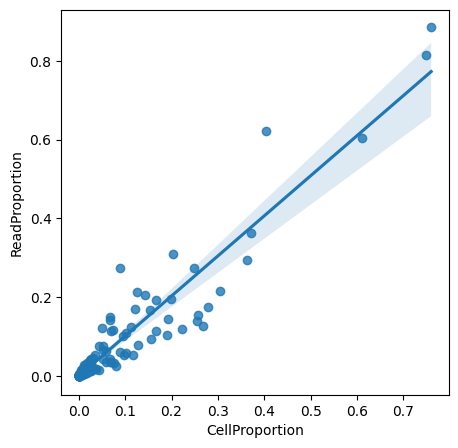

In [180]:
plt.figure(figsize=(5, 5))
sns.regplot(data=ReadProportionByCellType_C, 
                x='CellProportion', y='ReadProportion', 
                # **{'linewidth':0}, alpha=0.75, hue='PatientID',
                # legend=None,
                # palette=palette_e,
                )
# sns.lineplot(x=[i*0.1 for i in range(0, 4+1)], y=[i*0.1 for i in range(0, 4+1)], color='black')

scipy.stats.pearsonr( ReadProportionByCellType_C['CellProportion'], ReadProportionByCellType_C['ReadProportion'] )

In [181]:
dict_CellType_to_ReadProportion_C = dict()
for CellType, edf in ReadProportionByCellType_C.groupby('CellType', observed=True):
    print(CellType)
    dict_CellType_to_ReadProportion_C[CellType] = np.mean(edf['ReadProportion'])
    print(f'\t{round(np.mean(edf['ReadProportion']), 2)}\t{round(np.std(edf['ReadProportion']), 2)}')

CD4+ T
	0.11	0.07
CD8+ T
	0.1	0.06
Endothelial
	0.03	0.02
Enterocytes
	0.09	0.08
Fibroblast
	0.01	0.01
GC B
	0.0	0.0
Glial
	0.0	0.0
Goblet
	0.05	0.05
IGHA+ Plasma
	0.07	0.07
IGHG+ Plasma
	0.03	0.03
Intestinal stem
	0.0	0.0
Macrophage
	0.0	0.0
Mast
	0.01	0.01
Memory B
	0.01	0.01
Monocyte
	0.01	0.01
N/A
	0.01	0.01
NK
	0.01	0.01
Naive B
	0.01	0.01
Pericyte
	0.01	0.01
SMC
	0.0	0.0
SOX6+ Fibroblast
	0.0	0.0
Tumor cell
	0.45	0.25
cDC
	0.01	0.01
gd T
	0.01	0.01
pDC
	0.0	0.0


In [189]:
s = np.sum(list(dict_CellType_to_ReadProportion_C.values()))
dict_CellType_to_ReadProportion_C = { k:v/s for k,v in dict_CellType_to_ReadProportion_C.items() }
CellType_ReadProportion_C = pd.DataFrame.from_dict(dict_CellType_to_ReadProportion_C, orient='index')
CellType_ReadProportion_C.columns = ['ReadProportion']
CellType_ReadProportion_C

,ReadProportion
CD4+ T,0.111597
CD8+ T,0.093101
Endothelial,0.030447
Enterocytes,0.089342
Fibroblast,0.006793
GC B,0.003553
Glial,0.000813
Goblet,0.045263
IGHA+ Plasma,0.069694
IGHG+ Plasma,0.026606


In [206]:
intersecting_celltypes = set(dict_CellType_to_ReadProportion_C.keys()).intersection(set(dict_CellType_to_ReadProportion_J.keys()))
dict_CellType_to_ReadProportion = dict()

for k, v in dict_CellType_to_ReadProportion_C.items():
    if k not in intersecting_celltypes: continue 
    dict_CellType_to_ReadProportion[k]=[v]
for k, v in dict_CellType_to_ReadProportion_J.items():
    if k not in intersecting_celltypes: continue 
    dict_CellType_to_ReadProportion[k].append(v)

CellType_ReadProportion = pd.DataFrame.from_dict(dict_CellType_to_ReadProportion, orient='index')
CellType_ReadProportion.columns = ['ReadProportion_C', 'ReadProportion_J']

CellType_ReadProportion['difference'] = CellType_ReadProportion['ReadProportion_C'] - CellType_ReadProportion['ReadProportion_J']
CellType_ReadProportion.sort_values('difference')
# sns.scatterplot(data=CellType_ReadProportion[CellType_ReadProportion['difference']<=0.2], x='ReadProportion_C', y='ReadProportion_J',)

,ReadProportion_C,ReadProportion_J,difference
SMC,0.000723,0.002744,-0.002021
Glial,0.000813,0.001020,-0.000207
Macrophage,0.000857,0.078055,-0.077198
SOX6+ Fibroblast,0.001660,0.019043,-0.017383
GC B,0.003553,0.007380,-0.003827
pDC,0.004367,0.001994,0.002373
gd T,0.005273,0.003619,0.001653
cDC,0.005958,0.009845,-0.003887
Fibroblast,0.006793,0.069617,-0.062824
Monocyte,0.006903,0.056052,-0.049149


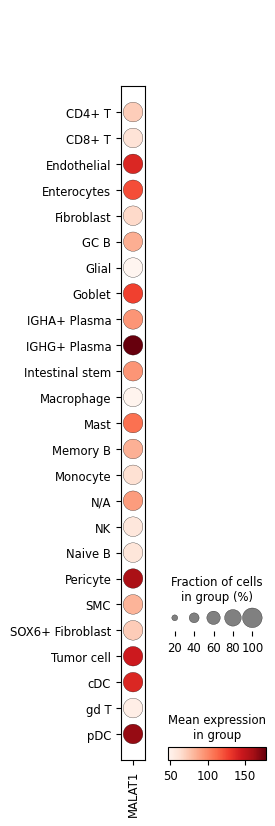

In [205]:
sc.pl.dotplot(adata_C, var_names=['MALAT1'], groupby='Manual_CellType_lvl_3')

## Test 1

### Prepare mixture of cells

In [51]:
# CellTypeName, CellProportion, ReadProportion, S_perc, H_perc, S_MSI_perc, H_MSI_perc
dict_CellType_to_parameters = {                                         # Cell  Read
    'Normal_1'  : [ 'Normal_1', .15,    .30, 0.2,   0.8,    0,   0 ],   # 15%   30%  
    'Normal_2'  : [ 'Normal_2', .8,     .22, 0.1,   0.9,    0,   0 ],   # 8%    22%
    'Normal_3'  : [ 'Normal_3', .12,    .03, 0.6,   0.4,    0,   0 ],   # 12%   3%
    'Normal_4'  : [ 'Normal_4', .5,     .15, 0.05,  0.95,   0,   0 ],   # 5%    15%
    'Tumor'     : [ 'Tumor',    .60,    .30, 0.4,   0.6,    .4, .3 ],   # 60%   30%
}

CellTypes = { CT : CellType( *param ) for CT, param in dict_CellType_to_parameters.items() }

### Calculate MSI read proportion via naive approach (tumor purity)

In [61]:
def naive_MSI_score( CellTypes, TotalReadCount ):
    for name, CT in CellTypes.items():
        if name == 'Tumor':
            MSI_read_count = CT.S_MSI_count + CT.H_MSI_count
            return MSI_read_count/TotalReadCount

def naive_MSI_score_purity_adjust( CellTypes, TotalReadCount ):
    for name, CT in CellTypes.items():
        if name == 'Tumor':
            MSI_read_count = CT.S_MSI_count + CT.H_MSI_count
            return (MSI_read_count/TotalReadCount)/CT.CellProportion
        
def true_MSI_score( CellTypes ):
    for name, CT in CellTypes.items():
        if name == 'Tumor':
            return (CT.S_MSI_count+CT.H_MSI_count)/(CT.S_count+CT.H_count)
        
naive_MSI_score(CellTypes, TotalReadCount), naive_MSI_score_purity_adjust(CellTypes, TotalReadCount), true_MSI_score(CellTypes) 

(0.102, 0.16999999999999998, 0.34)

### Calculate MSI read proportion using only housekeeping genes

In [67]:
def use_HK_only_MSI_score( CellTypes, ):
    
    TotalHouseKeepingReads = 0
    MSIHouseKeepingReads = 0

    for name, CT in CellTypes.items():
        TotalHouseKeepingReads += CT.H_count
        if name == 'Tumor':
            MSIHouseKeepingReads = CT.H_count
    
    return (MSIHouseKeepingReads/TotalHouseKeepingReads)

use_HK_only_MSI_score( CellTypes )

0.23300970873786409

## Test 2

In [72]:
# CellTypeName, CellProportion, ReadProportion, S_perc, H_perc, S_MSI_perc, H_MSI_perc
dict_CellType_to_parameters = {                                         # Cell  Read
    'Normal_1'  : [ 'Normal_1', .33,    .29, 0.625, 0.375,  0,  0 ],   # 33%    29%  
    'Normal_2'  : [ 'Normal_2', .33,    .38, 0.5,   0.5,    0,  0 ],   # 33%    38%
    'Tumor'     : [ 'Tumor',    .33,    .33, 0.43,  0.57,   1, .5 ],   # 33%    33%
}

CellTypes = { CT : CellType( *param ) for CT, param in dict_CellType_to_parameters.items() }

In [71]:
naive_MSI_score(CellTypes, TotalReadCount), naive_MSI_score_purity_adjust(CellTypes, TotalReadCount), true_MSI_score(CellTypes) 

(0.23595, 0.7085585585585585, 0.715)

In [75]:
use_HK_only_MSI_score( CellTypes )

0.3863613022491527